In [57]:
import json
import os
from pathlib import Path
import time
import copy
import datetime
import collections
import random
import platform
import pdb

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from fastai.dataset import open_image
import json
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2
from tqdm import tqdm

In [58]:
# params
SIZE = 224
EPOCHS = 5
BATCH_SIZE = 32
NUM_WORKERS = 4
SHOW_IMAGES = False

# static
IMAGES = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES = 'categories'
ID = 'id'
NAME = 'name'
IMAGE_ID = 'image_id'
BBOX = 'bbox'
CATEGORY_ID = 'category_id'
FILE_NAME = 'file_name'
IMAGE = 'image'
CATEGORY = 'category'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print('device:', device)

device: cpu


Adjust data dir path for Paperspace or Kaggle

In [60]:
home_dir = os.path.expanduser('~')

if platform.system() == 'Darwin': # MAC
    DATA_DIR = '/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/'
elif home_dir == '/home/paperspace':
    DATA_DIR = '/home/paperspace/data/pascal'
else: # kaggle
    DATA_DIR = '../input/pascal/pascal'

In [61]:
# could as this as a variable to the first "if" case above
home_dir

'/Users/aaron'

In [62]:
PATH = Path(DATA_DIR)
list(PATH.iterdir())

[PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/pascal_val2007.json'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/pascal_test2007.json'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/Annotations'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/pascal_train2007.json')]

In [63]:
train_data = json.load((PATH/'pascal_train2007.json').open())
val_data = json.load((PATH/'pascal_val2007.json').open())
test_data = json.load((PATH/'pascal_test2007.json').open())

print('train:', train_data.keys())
print('val:', val_data.keys())
print('test:', test_data.keys())

train: dict_keys(['images', 'type', 'annotations', 'categories'])
val: dict_keys(['images', 'type', 'annotations', 'categories'])
test: dict_keys(['images', 'type', 'annotations', 'categories'])


In [64]:
def preview_data(data):
    if isinstance(data, (list, tuple)):
        return data[0]
    elif isinstance(data, dict):
        return next(iter(data.items()))
    else:
        raise TypeError(f"Unsupported type: {type(data)}")

In [65]:
train_data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [66]:
preview_data(train_data[ANNOTATIONS])

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [67]:
preview_data(train_data[IMAGES])

{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

In [68]:
# all categories are the same
train_categories = {c[ID]-1:c[NAME] for c in train_data[CATEGORIES]}
val_categories = {c[ID]-1:c[NAME] for c in val_data[CATEGORIES]}
test_categories = {c[ID]-1:c[NAME] for c in test_data[CATEGORIES]}
assert train_categories == val_categories == test_categories

categories = train_categories
NUM_CATEGORIES = len(categories)
print('category count:', NUM_CATEGORIES)
print(categories)

category count: 20
{0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}


In [69]:
IMAGE_PATH = Path(PATH/'JPEGImages/')
list(IMAGE_PATH.iterdir())[:2]

[PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/003301.jpg'),
 PosixPath('/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/006279.jpg')]

Helper functions for setting up `pandas.DataFrame` fed to the torch `Dataset`

In [70]:
def get_filenames(data):
    filenames = {o[ID]:o[FILE_NAME] for o in data[IMAGES]}
    print('get_id_filename_dict')
    print('length:', len(filenames), 'next item:', next(iter(filenames.items())))
    return filenames

In [71]:
def get_image_ids(data):
    image_ids = [o[ID] for o in data[IMAGES]]
    print('get_image_ids')
    print('length:', len(image_ids), 'next item:', image_ids[0])
    return image_ids

In [72]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

[196, 174]

In [73]:
def get_full_filenames(id_filename_dict):
    # Returns a list of 2 item tuples (image_id, image_full_path)
    print('get_full_filenames')
    ret = [(k, f'{IMAGE_PATH}/{v}') for k,v in id_filename_dict.items()]
    print(preview_data(ret))
    return ret

### Train data structs

In [74]:
train_filenames = get_filenames(train_data)
train_image_ids = get_image_ids(train_data)
train_full_filenames = get_full_filenames(train_filenames)

get_id_filename_dict
length: 2501 next item: (12, '000012.jpg')
get_image_ids
length: 2501 next item: 12
get_full_filenames
(12, '/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/000012.jpg')


### Val data structs

In [75]:
val_filenames = get_filenames(val_data)
val_image_ids = get_image_ids(val_data)
val_full_filenames = get_full_filenames(val_filenames)

get_id_filename_dict
length: 2510 next item: (5, '000005.jpg')
get_image_ids
length: 2510 next item: 5
get_full_filenames
(5, '/Users/aaron/data/VOC2007/trainval/VOCdevkit/VOC2007/JPEGImages/000005.jpg')


# Image helper functions

In [76]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b, edgecolor='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=2))
    draw_outline(patch, 4)
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

# Multi-box Labels

### New Annotations Data struct

In [77]:
def get_new_train_ann(image_ids, data):
    """
    Returns a rank 2 array [n, 5]. 5 items in 2nd dimen are 4 bbox cords, last is the category
    """
    all_ann = {image_id:[] for image_id in image_ids}
    for x in data[ANNOTATIONS]:
        image_id = x[IMAGE_ID]
        bbox = x[BBOX]
        cat = [x[CATEGORY_ID]] # this is an int normally
        ann = np.concatenate([bbox, cat])
        if len(all_ann[image_id]) == 0:
            all_ann[image_id] = np.array([ann])
        else:
            prev = all_ann[image_id]
            new = ann
            all_ann[image_id] = np.reshape(np.concatenate([new, np.reshape(prev, -1)]), (-1, 5))
    return all_ann
    
new_val_ann = get_new_train_ann(val_image_ids, val_data)
preview_data(new_val_ann)

(5, array([[276, 185,  36,  35,   9],
        [240, 193,  55, 106,   9],
        [  4, 243,  63, 131,   9],
        [164, 263,  89, 109,   9],
        [262, 210,  62, 129,   9]]))

### Orig Annotations Data struct

In [78]:
def get_image_annotations(data):
    # returns a dict of {image_id: [((bbox, cat), ...)]} 
    # 1 item per image. Can be multi bbox per image
    ann = collections.defaultdict(lambda:[])
    for x in data[ANNOTATIONS]:
        ann[x[IMAGE_ID]].append([x[BBOX], x[CATEGORY_ID]-1]) # categories are 0 indexed now!
    return ann

train_ann = get_image_annotations(train_data)

In [79]:
train_ann[17]

[[[184, 61, 95, 138], 14], [[89, 77, 314, 259], 12]]

In [80]:
preview_data(train_ann)

(12, [[[155, 96, 196, 174], 6]])

### Random image with multi-box labels

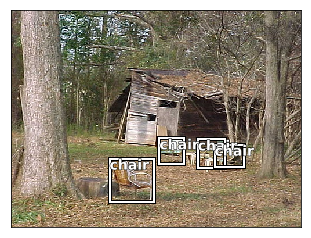

In [81]:
def show_random_multibox_image(ann, image_ids, filenames):
    image_id = random.choice(image_ids)
    im = open_image(str(IMAGE_PATH/filenames[image_id]))
    ax = show_img(im)
    for bbox, cat in ann[image_id]:
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])

# TRAIN dataset example
show_random_multibox_image(train_ann, train_image_ids, train_filenames)

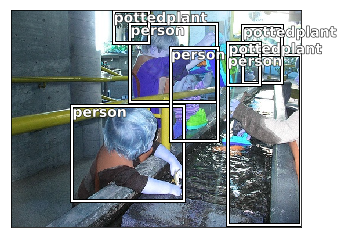

In [82]:
def show_random_multibox_image(ann, image_ids, filenames):
    image_id = random.choice(image_ids)
    im = cv2.imread(str(IMAGE_PATH/filenames[image_id]))
    ax = show_img(im)
    for bbox, cat in ann[image_id]:
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])

# TRAIN dataset example
show_random_multibox_image(train_ann, train_image_ids, train_filenames)

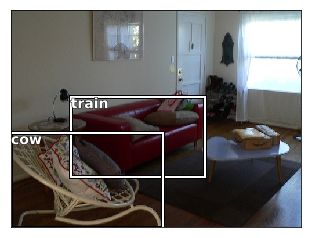

In [83]:
# new_train_ann version 

def new_show_random_multibox_image(ann, image_ids, filenames):
    image_id = random.choice(image_ids)
    im = open_image(str(IMAGE_PATH/filenames[image_id]))
    ax = show_img(im)
    for arr in ann[image_id]:
        bbox = arr[:4]
        cat = arr[-1]
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])

# TRAIN dataset example
new_train_ann = get_new_train_ann(train_image_ids, train_data)

new_show_random_multibox_image(new_train_ann, train_image_ids, train_filenames)

In [84]:
val_ann = get_image_annotations(val_data)

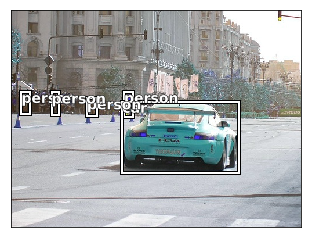

In [85]:
show_random_multibox_image(val_ann, val_image_ids, val_filenames)

Train Examples

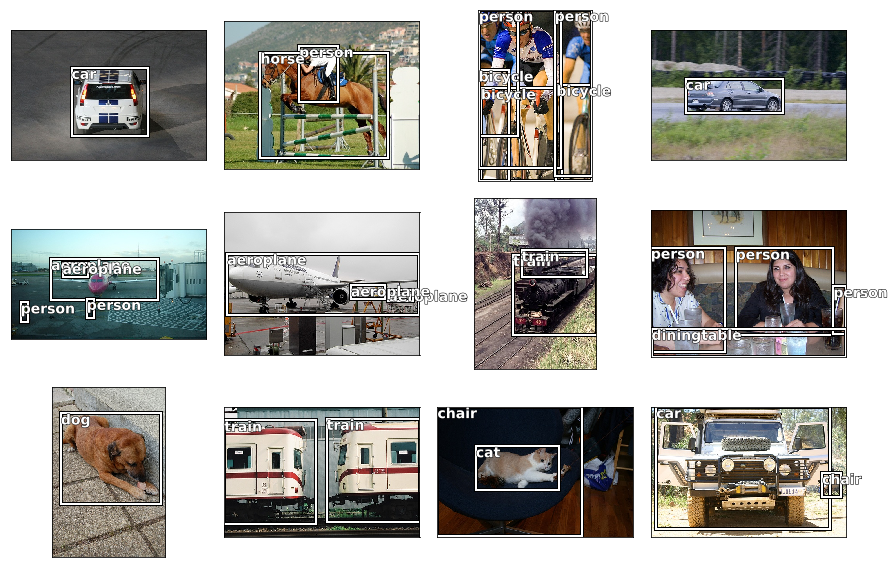

In [86]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    image_id = train_image_ids[i]
    image_anns = train_ann[image_id]
    im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
    ax = show_img(im, ax=ax)
    for bbox, cat in image_anns:
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])
plt.tight_layout()

VAL Examples

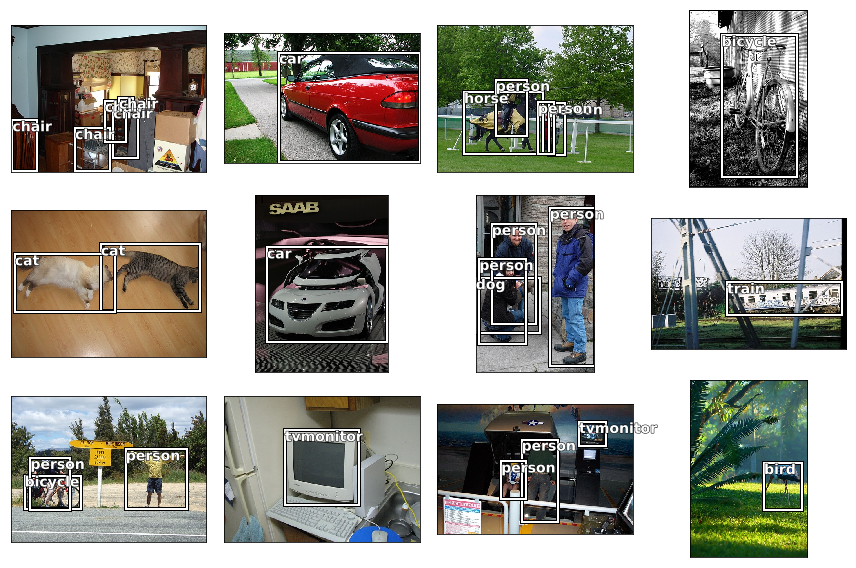

In [87]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    image_id = val_image_ids[i]
    image_anns = val_ann[image_id]
    im = open_image(str(IMAGE_PATH/val_filenames[image_id]))
    ax = show_img(im, ax=ax)
    for bbox, cat in image_anns:
        draw_rect(ax, bbox)
        draw_text(ax, bbox[:2], categories[cat])
plt.tight_layout()

# 4x4 Grid Model

In [88]:
anc_grid = 4
k = 1
anc_offset = 1/(anc_grid*2)
anc_offset

0.125

In [89]:
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), 4)
anc_x

array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625, 0.625, 0.625, 0.625, 0.875, 0.875,
       0.875, 0.875])

In [90]:
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), 4)
anc_y

array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375,
       0.625, 0.875])

In [91]:
anc_grid = 4
k = 1
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), 4)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), 4)
anc_centers = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_w = 1/anc_grid
anc_h = 1/anc_grid
anc_sizes = np.array([[anc_w, anc_h] for i in range(anc_grid*anc_grid)])
anc_sizes

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

In [92]:
np.concatenate([anc_centers, anc_sizes], axis=1)

array([[0.125, 0.125, 0.25 , 0.25 ],
       [0.125, 0.375, 0.25 , 0.25 ],
       [0.125, 0.625, 0.25 , 0.25 ],
       [0.125, 0.875, 0.25 , 0.25 ],
       [0.375, 0.125, 0.25 , 0.25 ],
       [0.375, 0.375, 0.25 , 0.25 ],
       [0.375, 0.625, 0.25 , 0.25 ],
       [0.375, 0.875, 0.25 , 0.25 ],
       [0.625, 0.125, 0.25 , 0.25 ],
       [0.625, 0.375, 0.25 , 0.25 ],
       [0.625, 0.625, 0.25 , 0.25 ],
       [0.625, 0.875, 0.25 , 0.25 ],
       [0.875, 0.125, 0.25 , 0.25 ],
       [0.875, 0.375, 0.25 , 0.25 ],
       [0.875, 0.625, 0.25 , 0.25 ],
       [0.875, 0.875, 0.25 , 0.25 ]])

In [93]:
anchors = torch.tensor(np.concatenate([anc_centers, anc_sizes], axis=1), requires_grad=False, dtype=torch.float)
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]])

In [94]:
grid_sizes = torch.tensor(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
grid_sizes

tensor([[0.2500]], dtype=torch.float64)

(0, 1)

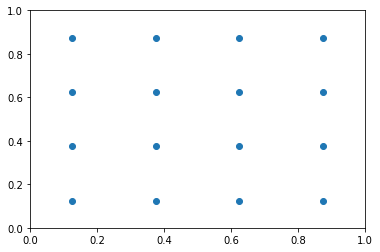

In [95]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [96]:
def hw2corners(center, hw):
    return torch.cat([center-hw/2, center+hw/2], dim=1)

# not in use, just for noting
center = anchors[:,:2]
hw = anchors[:,2:]

anchor_corners = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_corners

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]])

In [97]:
np.concatenate([center-hw/2, center+hw/2], axis=1)

array([[0.  , 0.  , 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.5 , 0.25, 0.75],
       [0.  , 0.75, 0.25, 1.  ],
       [0.25, 0.  , 0.5 , 0.25],
       [0.25, 0.25, 0.5 , 0.5 ],
       [0.25, 0.5 , 0.5 , 0.75],
       [0.25, 0.75, 0.5 , 1.  ],
       [0.5 , 0.  , 0.75, 0.25],
       [0.5 , 0.25, 0.75, 0.5 ],
       [0.5 , 0.5 , 0.75, 0.75],
       [0.5 , 0.75, 0.75, 1.  ],
       [0.75, 0.  , 1.  , 0.25],
       [0.75, 0.25, 1.  , 0.5 ],
       [0.75, 0.5 , 1.  , 0.75],
       [0.75, 0.75, 1.  , 1.  ]], dtype=float32)

In [98]:
anchor_corners[7]

tensor([0.2500, 0.7500, 0.5000, 1.0000])

(0, 1)

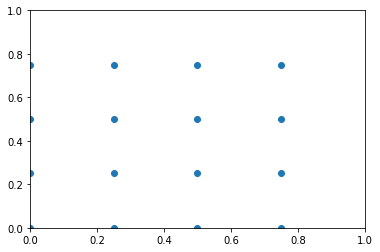

In [99]:
plt.scatter(anchor_corners[:,0], anchor_corners[:,1])
plt.xlim(0, 1)
plt.ylim(0, 1)

(0, 1)

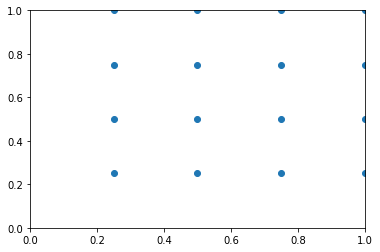

In [100]:
plt.scatter(anchor_corners[:,2], anchor_corners[:,3])
plt.xlim(0, 1)
plt.ylim(0, 1)

Calculate the `[0,1]` location for each object, in order to calculate the IoU

In [101]:
sample = preview_data(train_ann)
sample

(12, [[[155, 96, 196, 174], 6]])

In [102]:
image_id, ann = sample

In [103]:
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
im.shape

(333, 500, 3)

In [104]:
im_h = im.shape[0]
im_w = im.shape[1]

In [105]:
scaled_ann = [(np.divide(bbox, [im_w, im_h, im_w, im_h]), cat) for bbox,cat in ann]
scaled_ann

[(array([0.31   , 0.28829, 0.392  , 0.52252]), 6)]

In [106]:
np.divide(im.shape, [im_h, im_w, 1])

array([1., 1., 3.])

Show the above Anchor Boxes data struct

In [107]:
def scale_pascal_bb(bbox, image, size):
    """
    Returns a bbox scaled to the target `size`
    
    Args:
        bbox (1d array): pascal_bb [x, y, x2, y2]
        image (3d array): HWC
        size (scalar): target image size that bbox should be scaled to
    """
    im_w = image.shape[1]
    im_h = image.shape[0]
    return np.multiply(np.divide(bbox, [im_w, im_h, im_w, im_h]), size)

(364, 480, 3)


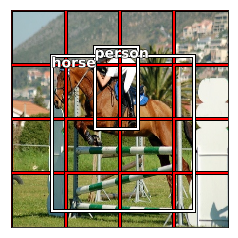

In [108]:
# image_id = random.choice(train_image_ids)
image_id = train_image_ids[1]
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
print(im.shape)
resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
ax = show_img(resized_image)
for bbox in anchor_corners:
    draw_rect(ax, bbox*224, edgecolor='red')
for bbox, cat in train_ann[image_id]:
    bbox = scale_pascal_bb(bbox, im, SIZE)
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], categories[cat])

In [109]:
# IoU for above image
image_id = train_image_ids[1]
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))

bbox1, bbox2 = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]
bbox1, bbox2

(array([85.86667, 37.53846, 44.33333, 84.92308]),
 array([ 41.53333,  47.38462, 146.53333, 159.38462]))

In [110]:
# calc area for 'person'
bbox = bbox2
y1 = bbox[1]
x1 = bbox[0]
y2 = bbox[1] + bbox[3] - 1
x2 = bbox[0] + bbox[2] - 1
(x2-x1)*(y2-y1)

23050.241025641026

In [111]:
def fastai_bbs(bbs):
    return np.array([[bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1] for bb in bbs])

bbs = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]

fastai_bbs(bbs)

array([[ 37.53846,  85.86667, 121.46154, 129.2    ],
       [ 47.38462,  41.53333, 205.76923, 187.06667]])

In [112]:
def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

bb = fastai_bb(bbox2)
bb

array([ 47.38462,  41.53333, 205.76923, 187.06667])

In [113]:
y1, x1, y2, x2 = bb
(x2-x1)*(y2-y1)

23050.241025641026

In [114]:
# horse area
bbox = bbox2
print(bbox)
y1 = bbox[1]
x1 = bbox[0]
y2 = bbox[1] + bbox[3]
x2 = bbox[0] + bbox[2]
(x2-x1)*(y2-y1)

[ 41.53333  47.38462 146.53333 159.38462]


23355.158974358976

In [115]:
SIZE**2

50176

In [116]:
ab_224 = anchor_corners*SIZE
ab224 = ab_224
y1 = ab_224[:,0]
x1 = ab_224[:,1]
y2 = ab_224[:,2]
x2 = ab_224[:,3]
ab_area = (x2-x1)*(y2-y1)
ab_area

tensor([3136., 3136., 3136., 3136., 3136., 3136., 3136., 3136., 3136., 3136.,
        3136., 3136., 3136., 3136., 3136., 3136.])

In [117]:
bb

array([ 47.38462,  41.53333, 205.76923, 187.06667])

In [118]:
single_ab_area = 56**2.
single_ab_area

3136.0

In [119]:
y1, x1, y2, x2 = bb
bb_area = (x2-x1)*(y2-y1)
bb_area

23050.241025641026

In [120]:
union = single_ab_area + bb_area
union

26186.241025641026

In [121]:
# calc intersection
# bb[:2]
bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (-1, 4))
bb16.shape

(16, 4)

In [122]:
ab224.shape

torch.Size([16, 4])

In [123]:
max_xy = np.maximum(ab224[:,:2], bb16[:,:2])
max_xy.shape

torch.Size([16, 2])

In [124]:
min_xy = np.minimum(ab224[:,2:], bb16[:,2:])
min_xy.shape

torch.Size([16, 2])

In [125]:
intersect = np.abs(max_xy - min_xy)
intersect.shape

torch.Size([16, 2])

In [126]:
sinble_bb_iou = intersect[:,0] * intersect[:,1]
sinble_bb_iou

tensor([ 124.6359,  482.4615,  482.4615,  164.2667,  810.1333, 3136.0000,
        3136.0000, 1067.7333,  810.1333, 3136.0000, 3136.0000, 1067.7333,
         546.3949, 2115.0769, 2115.0769,  720.1333], dtype=torch.float64)

In [127]:
8.61538 * 14.46667

124.63585938460001

## Intersection part of IoU for a single bbox

In [128]:
# calculate `intersect` in a single function
def get_intersect(bbox, anchor_corners):
    bb = fastai_bb(bbox)
    ab224 = anchor_corners*SIZE
    bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (-1, 4))
    max_xy = np.maximum(ab224[:,:2], bb16[:,:2])
    min_xy = np.minimum(ab224[:,2:], bb16[:,2:])
    intersect = np.abs(max_xy - min_xy)
    return intersect[:,0] * intersect[:,1]

get_intersect(bbox2, anchor_corners)

tensor([ 124.6359,  482.4615,  482.4615,  164.2667,  810.1333, 3136.0000,
        3136.0000, 1067.7333,  810.1333, 3136.0000, 3136.0000, 1067.7333,
         546.3949, 2115.0769, 2115.0769,  720.1333], dtype=torch.float64)

In [129]:
bboxes = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]
bbox = bboxes # [bbox2]
bb = [fastai_bb(bb) for bb in bbox]
ab224 = anchor_corners*SIZE
bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (-1, 4))
# max_xy = np.maximum(ab224[:,:2], bb16[:,:2])
# min_xy = np.minimum(ab224[:,2:], bb16[:,2:])
# intersect = np.abs(max_xy - min_xy)
# bbox_intersect = intersect[:,0] * intersect[:,1]

In [130]:
ab224[:,:2].shape

torch.Size([16, 2])

In [131]:
bb16 = np.reshape(np.tile(bb, ab224.shape[0]), (len(bb), -1, 4))
bb16.shape

(2, 16, 4)

In [132]:
max_xy = np.maximum(ab224[:,:2], bb16[:,:,:2])
max_xy.shape

torch.Size([2, 16, 2])

In [133]:
min_xy = np.minimum(ab224[:,2:], bb16[:,:,2:])
min_xy.shape

torch.Size([2, 16, 2])

In [134]:
intersect = np.abs(max_xy - min_xy)
intersect.shape

torch.Size([2, 16, 2])

In [135]:
bbox_intersect = intersect[:,:,0] * intersect[:,:,1]
bbox_intersect.shape

torch.Size([2, 16])

In [136]:
bbox1, bbox2 = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]]

np.reshape(np.concatenate(
    [get_intersect(bbox1, anchor_corners),
    get_intersect(bbox2, anchor_corners)]
), (2,-1)) == bbox_intersect

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

# IoU not I over single_bb_area

In [137]:
bbox = np.array([scale_pascal_bb(bbox, im, SIZE) for bbox,cat in train_ann[image_id]])

bbs = np.array([fastai_bb(bb) for bb in bbox])
ab224 = anchor_corners*SIZE
bb16 = np.reshape(np.tile(bbs, ab224.shape[0]), (len(bbs), -1, 4))
# max_xy = np.maximum(bbs[:,:2], bb16[:,:,:2])
# min_xy = np.minimum(bbs[:,2:], bb16[:,:,2:])
# intersect = np.abs(max_xy - min_xy)
# bbs_intersect = intersect[:,:,0] * intersect[:,:,1]
# bbs_intersect

In [138]:
ab224.shape

torch.Size([16, 4])

In [139]:
bb16.shape

(2, 16, 4)

In [140]:
bbs[:,2:].shape, bb16[:,:,2:].shape

((2, 2), (2, 16, 2))

In [141]:
bbs

array([[ 37.53846,  85.86667, 121.46154, 129.2    ],
       [ 47.38462,  41.53333, 205.76923, 187.06667]])

In [142]:
bbs = bbs / SIZE
bbs

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [143]:
anchor_corners

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]])

## IoU bb

In [144]:
bb = bbs[1]
bb

array([0.21154, 0.18542, 0.91861, 0.83512])

In [145]:
anchor_corners[:,:2]

tensor([[0.0000, 0.0000],
        [0.0000, 0.2500],
        [0.0000, 0.5000],
        [0.0000, 0.7500],
        [0.2500, 0.0000],
        [0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.5000, 0.0000],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.7500, 0.0000],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500]])

In [146]:
bb[:2]

array([0.21154, 0.18542])

In [147]:
max_xy = np.maximum(bb[:2], anchor_corners[:,:2])
max_xy

tensor([[0.2115, 0.1854],
        [0.2115, 0.2500],
        [0.2115, 0.5000],
        [0.2115, 0.7500],
        [0.2500, 0.1854],
        [0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.5000, 0.1854],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.7500, 0.1854],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500]], dtype=torch.float64)

In [148]:
min_xy = np.minimum(bb[2:], anchor_corners[:,2:])
min_xy

tensor([[0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.2500, 0.8351],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.5000, 0.8351],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500],
        [0.7500, 0.8351],
        [0.9186, 0.2500],
        [0.9186, 0.5000],
        [0.9186, 0.7500],
        [0.9186, 0.8351]], dtype=torch.float64)

In [149]:
intersect_xy = np.abs(min_xy - max_xy)
intersect_xy

tensor([[0.0385, 0.0646],
        [0.0385, 0.2500],
        [0.0385, 0.2500],
        [0.0385, 0.0851],
        [0.2500, 0.0646],
        [0.2500, 0.2500],
        [0.2500, 0.2500],
        [0.2500, 0.0851],
        [0.2500, 0.0646],
        [0.2500, 0.2500],
        [0.2500, 0.2500],
        [0.2500, 0.0851],
        [0.1686, 0.0646],
        [0.1686, 0.2500],
        [0.1686, 0.2500],
        [0.1686, 0.0851]], dtype=torch.float64)

In [150]:
intersect_xy = np.abs(min_xy - max_xy)
intersect = intersect_xy[:,0] * intersect_xy[:,1]
intersect

tensor([0.0025, 0.0096, 0.0096, 0.0033, 0.0161, 0.0625, 0.0625, 0.0213, 0.0161,
        0.0625, 0.0625, 0.0213, 0.0109, 0.0422, 0.0422, 0.0144],
       dtype=torch.float64)

## IoU bbs

In [151]:
bbs

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [152]:
bbs[:,:2]

array([[0.16758, 0.38333],
       [0.21154, 0.18542]])

In [153]:
anchor_corners.shape

torch.Size([16, 4])

In [154]:
anc_bbs = np.stack([anchor_corners, anchor_corners])
anc_bbs = anchor_corners
anc_bbs

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]])

In [155]:
anc_bbs.shape

torch.Size([16, 4])

In [156]:
anc_bbs.shape

torch.Size([16, 4])

In [157]:
bbs

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [158]:
bbs16 = np.reshape(np.tile(bbs, 16), (2,16,4))
bbs16.shape

(2, 16, 4)

In [159]:
bbs

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [160]:
bbs[:,:2]

array([[0.16758, 0.38333],
       [0.21154, 0.18542]])

In [161]:
ab224[:,:2]

tensor([[  0.,   0.],
        [  0.,  56.],
        [  0., 112.],
        [  0., 168.],
        [ 56.,   0.],
        [ 56.,  56.],
        [ 56., 112.],
        [ 56., 168.],
        [112.,   0.],
        [112.,  56.],
        [112., 112.],
        [112., 168.],
        [168.,   0.],
        [168.,  56.],
        [168., 112.],
        [168., 168.]])

In [162]:
(anc_bbs[:,:2] * SIZE == ab224[:,:2]).all()

tensor(1, dtype=torch.uint8)

In [163]:
# bb16[:,:,:2]

In [164]:
(bbs16[:,:,:2] * SIZE == bb16[:,:,:2]).all()

True

In [165]:
# max_xy = np.maximum(ab224[:,:2], bb16[:,:,:2])
# min_xy = np.minimum(ab224[:,2:], bb16[:,:,2:])
# intersect = np.abs(max_xy - min_xy)
# bbs_intersect = intersect[:,:,0] * intersect[:,:,1]
# bbs_intersect

In [166]:
# anc_bbs[:,:2]

In [167]:
# bbs16[:,:,:2]

In [168]:
bbs / SIZE

array([[0.00075, 0.00171, 0.00242, 0.00257],
       [0.00094, 0.00083, 0.0041 , 0.00373]])

In [169]:
np.maximum(anchor_corners[:,:2], bbs16[:,:,:2])

tensor([[[0.1676, 0.3833],
         [0.1676, 0.3833],
         [0.1676, 0.5000],
         [0.1676, 0.7500],
         [0.2500, 0.3833],
         [0.2500, 0.3833],
         [0.2500, 0.5000],
         [0.2500, 0.7500],
         [0.5000, 0.3833],
         [0.5000, 0.3833],
         [0.5000, 0.5000],
         [0.5000, 0.7500],
         [0.7500, 0.3833],
         [0.7500, 0.3833],
         [0.7500, 0.5000],
         [0.7500, 0.7500]],

        [[0.2115, 0.1854],
         [0.2115, 0.2500],
         [0.2115, 0.5000],
         [0.2115, 0.7500],
         [0.2500, 0.1854],
         [0.2500, 0.2500],
         [0.2500, 0.5000],
         [0.2500, 0.7500],
         [0.5000, 0.1854],
         [0.5000, 0.2500],
         [0.5000, 0.5000],
         [0.5000, 0.7500],
         [0.7500, 0.1854],
         [0.7500, 0.2500],
         [0.7500, 0.5000],
         [0.7500, 0.7500]]], dtype=torch.float64)

In [170]:
np.minimum(anchor_corners[:,2:], bbs16[:,:,2:])

tensor([[[0.2500, 0.2500],
         [0.2500, 0.5000],
         [0.2500, 0.5768],
         [0.2500, 0.5768],
         [0.5000, 0.2500],
         [0.5000, 0.5000],
         [0.5000, 0.5768],
         [0.5000, 0.5768],
         [0.5422, 0.2500],
         [0.5422, 0.5000],
         [0.5422, 0.5768],
         [0.5422, 0.5768],
         [0.5422, 0.2500],
         [0.5422, 0.5000],
         [0.5422, 0.5768],
         [0.5422, 0.5768]],

        [[0.2500, 0.2500],
         [0.2500, 0.5000],
         [0.2500, 0.7500],
         [0.2500, 0.8351],
         [0.5000, 0.2500],
         [0.5000, 0.5000],
         [0.5000, 0.7500],
         [0.5000, 0.8351],
         [0.7500, 0.2500],
         [0.7500, 0.5000],
         [0.7500, 0.7500],
         [0.7500, 0.8351],
         [0.9186, 0.2500],
         [0.9186, 0.5000],
         [0.9186, 0.7500],
         [0.9186, 0.8351]]], dtype=torch.float64)

In [171]:
intersect = np.abs(np.maximum(anchor_corners[:,:2], bbs16[:,:,:2]) - np.minimum(anchor_corners[:,2:], bbs16[:,:,2:]))
intersect

tensor([[[0.0824, 0.1333],
         [0.0824, 0.1167],
         [0.0824, 0.0768],
         [0.0824, 0.1732],
         [0.2500, 0.1333],
         [0.2500, 0.1167],
         [0.2500, 0.0768],
         [0.2500, 0.1732],
         [0.0422, 0.1333],
         [0.0422, 0.1167],
         [0.0422, 0.0768],
         [0.0422, 0.1732],
         [0.2078, 0.1333],
         [0.2078, 0.1167],
         [0.2078, 0.0768],
         [0.2078, 0.1732]],

        [[0.0385, 0.0646],
         [0.0385, 0.2500],
         [0.0385, 0.2500],
         [0.0385, 0.0851],
         [0.2500, 0.0646],
         [0.2500, 0.2500],
         [0.2500, 0.2500],
         [0.2500, 0.0851],
         [0.2500, 0.0646],
         [0.2500, 0.2500],
         [0.2500, 0.2500],
         [0.2500, 0.0851],
         [0.1686, 0.0646],
         [0.1686, 0.2500],
         [0.1686, 0.2500],
         [0.1686, 0.0851]]], dtype=torch.float64)

In [172]:
intersect[:,:,0] * intersect[:,:,1]

tensor([[0.0110, 0.0096, 0.0063, 0.0143, 0.0333, 0.0292, 0.0192, 0.0433, 0.0056,
         0.0049, 0.0032, 0.0073, 0.0277, 0.0242, 0.0160, 0.0360],
        [0.0025, 0.0096, 0.0096, 0.0033, 0.0161, 0.0625, 0.0625, 0.0213, 0.0161,
         0.0625, 0.0625, 0.0213, 0.0109, 0.0422, 0.0422, 0.0144]],
       dtype=torch.float64)

### `get_intersection` - i part of IoU

In [173]:
def get_intersect(ann):
    # returns the i part of IoU scaled [0,1]
    bboxes = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in ann]
    bbs = np.array([fastai_bb(bb) for bb in bboxes]) / SIZE
    bbs16 = np.reshape(np.tile(bbs, 16), (2,16,4))
    intersect = np.abs(np.maximum(anchor_corners[:,:2], bbs16[:,:,:2]) - np.minimum(anchor_corners[:,2:], bbs16[:,:,2:]))
    return intersect[:,:,0] * intersect[:,:,1]

image_id = 17
ann = train_ann[image_id]
get_intersect(ann)

tensor([[0.0110, 0.0096, 0.0063, 0.0143, 0.0333, 0.0292, 0.0192, 0.0433, 0.0056,
         0.0049, 0.0032, 0.0073, 0.0277, 0.0242, 0.0160, 0.0360],
        [0.0025, 0.0096, 0.0096, 0.0033, 0.0161, 0.0625, 0.0625, 0.0213, 0.0161,
         0.0625, 0.0625, 0.0213, 0.0109, 0.0422, 0.0422, 0.0144]],
       dtype=torch.float64)

`scale_pascal_bbs`

In [174]:
def scale_pascal_bbs(bbs, im):
    im_w = im.shape[1]
    im_h = im.shape[0]
    return np.multiply(np.divide(bbs, [im_w, im_h, im_w, im_h]), SIZE)

image_id = 17
pascal_bbs = [a[0] for a in train_ann[image_id]]
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
pascal_bbs = scale_pascal_bbs(pascal_bbs, im)
pascal_bbs

array([[ 85.86667,  37.53846,  44.33333,  84.92308],
       [ 41.53333,  47.38462, 146.53333, 159.38462]])

In [175]:
pascal_bbs / SIZE

array([[0.38333, 0.16758, 0.19792, 0.37912],
       [0.18542, 0.21154, 0.65417, 0.71154]])

### `fastai_bbs`

In [176]:
def fastai_bbs(bbox, im):
    im_w = im.shape[1]
    im_h = im.shape[0]
    bbox = np.divide(bbox, [im_w, im_h, im_w, im_h])
    return np.array([bbox[:,1], bbox[:,0], bbox[:,3]+bbox[:,1]-(1/SIZE), bbox[:,2]+bbox[:,0]-(1/SIZE)]).T

def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

image_id = 17
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
bbox = np.array([a[0] for a in train_ann[image_id]])
fastai_bbs(bbox, im)

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [177]:
fastai_bbs(bbox, im) * SIZE

array([[ 37.53846,  85.86667, 121.46154, 129.2    ],
       [ 47.38462,  41.53333, 205.76923, 187.06667]])

In [178]:
bbox = np.array([a[0] for a in ann])
bboxes = scale_pascal_bbs(bbox, im)
np.array([fastai_bb(bb) for bb in bboxes])

array([[ 37.53846,  85.86667, 121.46154, 129.2    ],
       [ 47.38462,  41.53333, 205.76923, 187.06667]])

In [179]:
# data examples
# pascal_bbs = np.array([[85.86667, 37.53846, 44.33333, 84.92308],
#                        [ 41.53333,  47.38462, 146.53333, 159.38462]])

# scaled_bbs_fastai = np.array([[0.16758, 0.38333, 0.54224, 0.57679],
#                            [0.21154, 0.18542, 0.91861, 0.83512]])

# bbs_fastai_224 = np.array([[ 37.53846,  85.86667, 121.46154, 129.2    ],
#                            [ 47.38462,  41.53333, 205.76923, 187.06667]])

In [180]:
def unscaled_fastai_bbs(bbox, im):
    im_w = im.shape[1]
    im_h = im.shape[0]
    bbox = np.divide(bbox, [im_w, im_h, im_w, im_h])
    return np.multiply(np.array([bbox[:,1], bbox[:,0], bbox[:,3]+bbox[:,1]-(1/SIZE), bbox[:,2]+bbox[:,0]-(1/SIZE)]).T, SIZE)

image_id = 17
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
bbox = np.array([a[0] for a in train_ann[image_id]])
unscaled_fastai_bbs(bbox, im)

array([[ 37.53846,  85.86667, 121.46154, 129.2    ],
       [ 47.38462,  41.53333, 205.76923, 187.06667]])

In [181]:
def scaled_fastai_bbs(bbox, im):
    im_w = im.shape[1]
    im_h = im.shape[0]
    bbox = np.divide(bbox, [im_w, im_h, im_w, im_h])
    return np.array([bbox[:,1], bbox[:,0], bbox[:,3]+bbox[:,1]-(1/SIZE), bbox[:,2]+bbox[:,0]-(1/SIZE)]).T

image_id = 17
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
bbox = np.array([a[0] for a in train_ann[image_id]])
scaled_fastai_bbs(bbox, im)

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [182]:
bbox * 1.

array([[184.,  61.,  95., 138.],
       [ 89.,  77., 314., 259.]])

In [183]:
# using loops

def get_intersect(ann):
    # returns the i part of IoU scaled [0,1]
    bboxes = [scale_pascal_bb(bbox, im, SIZE) for bbox,cat in ann]
    bbs = np.array([fastai_bb(bb) for bb in bboxes]) / SIZE
    bbs16 = np.reshape(np.tile(bbs, 16), (2,16,4))
    intersect = np.abs(np.maximum(anchor_corners[:,:2], bbs16[:,:,:2]) - np.minimum(anchor_corners[:,2:], bbs16[:,:,2:]))
    return intersect[:,:,0] * intersect[:,:,1]

image_id = 17
ann = train_ann[image_id]
get_intersect(ann)

tensor([[0.0110, 0.0096, 0.0063, 0.0143, 0.0333, 0.0292, 0.0192, 0.0433, 0.0056,
         0.0049, 0.0032, 0.0073, 0.0277, 0.0242, 0.0160, 0.0360],
        [0.0025, 0.0096, 0.0096, 0.0033, 0.0161, 0.0625, 0.0625, 0.0213, 0.0161,
         0.0625, 0.0625, 0.0213, 0.0109, 0.0422, 0.0422, 0.0144]],
       dtype=torch.float64)

### `get_intersect2` i part of IoU without loops

In [184]:
def scaled_fastai_bbs(bbox, im):
    im_w = im.shape[1]
    im_h = im.shape[0]
    bbox = np.divide(bbox, [im_w, im_h, im_w, im_h])
    return np.array([bbox[:,1], bbox[:,0], bbox[:,3]+bbox[:,1]-(1/SIZE), bbox[:,2]+bbox[:,0]-(1/SIZE)]).T

image_id = 17
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
bbox = np.array([a[0] for a in train_ann[image_id]])
scaled_fastai_bbs(bbox, im)

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [185]:
def get_intersect2(ann, im):
    # returns the i part of IoU scaled [0,1]
    bbox = np.array([a[0] for a in ann])
    bbs = scaled_fastai_bbs(bbox, im)
    bbs16 = np.reshape(np.tile(bbs, 16), (2,16,4))
    intersect = np.abs(np.maximum(anchor_corners[:,:2], bbs16[:,:,:2]) - np.minimum(anchor_corners[:,2:], bbs16[:,:,2:]))
    return intersect[:,:,0] * intersect[:,:,1]

image_id = 17
ann = train_ann[image_id]
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
get_intersect(ann) - get_intersect2(ann, im)

tensor([[ 0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
          0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [186]:
intersect = get_intersect2(ann, im).numpy()
intersect

array([[0.01099, 0.00962, 0.00633, 0.01428, 0.03333, 0.02917, 0.0192 , 0.0433 , 0.00563, 0.00493, 0.00324,
        0.00732, 0.0277 , 0.02424, 0.01595, 0.03599],
       [0.00248, 0.00962, 0.00962, 0.00327, 0.01615, 0.0625 , 0.0625 , 0.02128, 0.01615, 0.0625 , 0.0625 ,
        0.02128, 0.01089, 0.04215, 0.04215, 0.01435]])

## `get_iou`

In [187]:
grid_cells = 16
ab_area = 1. / grid_cells
ab_area

0.0625

In [188]:
np.square(4)

16

In [189]:
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
bbox = np.array([a[0] for a in train_ann[image_id]])
bbs = scaled_fastai_bbs(bbox, im)
bbs

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [198]:
grid_size = 4

def get_ancb_area():
    "Returns the [0,1] normalized area of a single anchor box"
    return 1. / np.square(grid_size)

ab_area = get_ancb_area()
assert ab_area == 0.0625, ab_area

def get_bbs_area(bbs, im):
    "Returns a np.array of the [0,1] normalized bbs area"
    bbs = scaled_fastai_bbs(bbs, im)
    return np.abs(bbs[:,0]-bbs[:,2])*np.abs(bbs[:,1]-bbs[:,3])

ann = train_ann[image_id]
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
bbs = np.array([a[0] for a in ann])
bbs_area = get_bbs_area(bbs, im)
bbs_area

array([0.07248, 0.45939])

In [199]:
union_area = ab_area + bbs_area
union_area

array([0.13498, 0.52189])

In [202]:
iou = (intersect.T / union_area).T
iou

array([[0.08141, 0.07124, 0.04689, 0.10576, 0.24695, 0.21608, 0.14222, 0.32082, 0.04172, 0.03651, 0.02403,
        0.0542 , 0.20523, 0.17958, 0.11819, 0.26661],
       [0.00476, 0.01842, 0.01842, 0.00627, 0.03094, 0.11976, 0.11976, 0.04077, 0.03094, 0.11976, 0.11976,
        0.04077, 0.02087, 0.08077, 0.08077, 0.0275 ]])

## `overlaps`

In [205]:
overlaps = torch.tensor(iou)
overlaps

tensor([[0.0814, 0.0712, 0.0469, 0.1058, 0.2470, 0.2161, 0.1422, 0.3208, 0.0417,
         0.0365, 0.0240, 0.0542, 0.2052, 0.1796, 0.1182, 0.2666],
        [0.0048, 0.0184, 0.0184, 0.0063, 0.0309, 0.1198, 0.1198, 0.0408, 0.0309,
         0.1198, 0.1198, 0.0408, 0.0209, 0.0808, 0.0808, 0.0275]],
       dtype=torch.float64)

In [206]:
overlaps.max(1)

(tensor([0.3208, 0.1198], dtype=torch.float64), tensor([7, 5]))

In [207]:
overlaps.max(0)

(tensor([0.0814, 0.0712, 0.0469, 0.1058, 0.2470, 0.2161, 0.1422, 0.3208, 0.0417,
         0.1198, 0.1198, 0.0542, 0.2052, 0.1796, 0.1182, 0.2666],
        dtype=torch.float64),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]))

## `map_to_ground_truth`

In [208]:
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99

    # sets the gt_idx equal to the obj_idx for each prior_idx
    for i,o in enumerate(prior_idx):
        gt_idx[o] = i
    return gt_overlap,gt_idx

gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_overlap, gt_idx

(tensor([0.0814, 0.0712, 0.0469, 0.1058, 0.2470, 1.9900, 0.1422, 1.9900, 0.0417,
         0.1198, 0.1198, 0.0542, 0.2052, 0.1796, 0.1182, 0.2666],
        dtype=torch.float64),
 tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]))

## `gt_bbs`

In [209]:
im = open_image(str(IMAGE_PATH/train_filenames[image_id]))
bbox = np.array([a[0] for a in train_ann[image_id]])
bbs = scaled_fastai_bbs(bbox, im)
bbs

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512]])

In [211]:
# what the Dataset should return for the `bbs` labels
bbs[gt_idx]

array([[0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.21154, 0.18542, 0.91861, 0.83512],
       [0.21154, 0.18542, 0.91861, 0.83512],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679],
       [0.16758, 0.38333, 0.54224, 0.57679]])

## `gt_clas`

In [212]:
cats = np.array([a[1] for a in train_ann[image_id]])
cats

array([14, 12])

In [216]:
cats[gt_idx]

array([14, 14, 14, 14, 14, 12, 14, 14, 14, 12, 12, 14, 14, 14, 14, 14])

## `Dataset` to return `gt_bbs` and `gt_cats` per the `grid_size`